# CS6495 - tutorial 6

## Machine translation 
Machine translation(MT) is the process of using artificial intelligence to automatically translate text from one language to another without human involvement. Modern machine translation goes beyond simple word-to-word translation to communicate the full meaning of the original language text in the target language.
It is one of several tasks you can formulate as a sequence-to-sequence problem, a powerful framework for returning some output from an input, like translation or summarization. Translation systems are commonly used for translation between different language texts.

Goals:

  1. Finetune T5 on the English-French subset of the OPUS Books dataset to translate English text to French.
  2. Use your finetuned model for inference.

In [1]:
!pip install transformers datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from datasets import load_dataset
books = load_dataset("opus_books", "en-fr")
books = books["train"].train_test_split(test_size=0.2)

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-fr/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
books

DatasetDict({
    train: Dataset({
        features: ['id', 'translation'],
        num_rows: 101668
    })
    test: Dataset({
        features: ['id', 'translation'],
        num_rows: 25417
    })
})

We use the T5 as our model to finish the translation task. The T5 model was presented in Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer by Colin Raffel, Noam Shazeer, Adam Roberts, Katherine Lee, Sharan Narang, Michael Matena, Yanqi Zhou, Wei Li, Peter J. Liu.

T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

T5 uses relative scalar embeddings. Encoder input padding can be done on the left and on the right.

T5 comes in different sizes:

1. t5-small

2. t5-base

3. t5-large

4. t5-3b

5. t5-11b.

Based on the original T5 model, Google has released some follow-up works:

T5v1.1: T5v1.1 is an improved version of T5 with some architectural tweaks, and is pre-trained on C4 only without mixing in the supervised tasks.

mT5: mT5 is a multilingual T5 model. It is pre-trained on the mC4 corpus, which includes 101 languages. 

byT5: byT5 is a T5 model pre-trained on byte sequences rather than SentencePiece subword token sequences. 

flanT5: FLAN-T5 was released in the paper Scaling Instruction-Finetuned Language Models - it is an enhanced version of T5 that has been finetuned in a mixture of tasks.

The next step is to load a T5 tokenizer to process the English-French language pairs:

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-small")

/usr/local/lib/python3.8/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


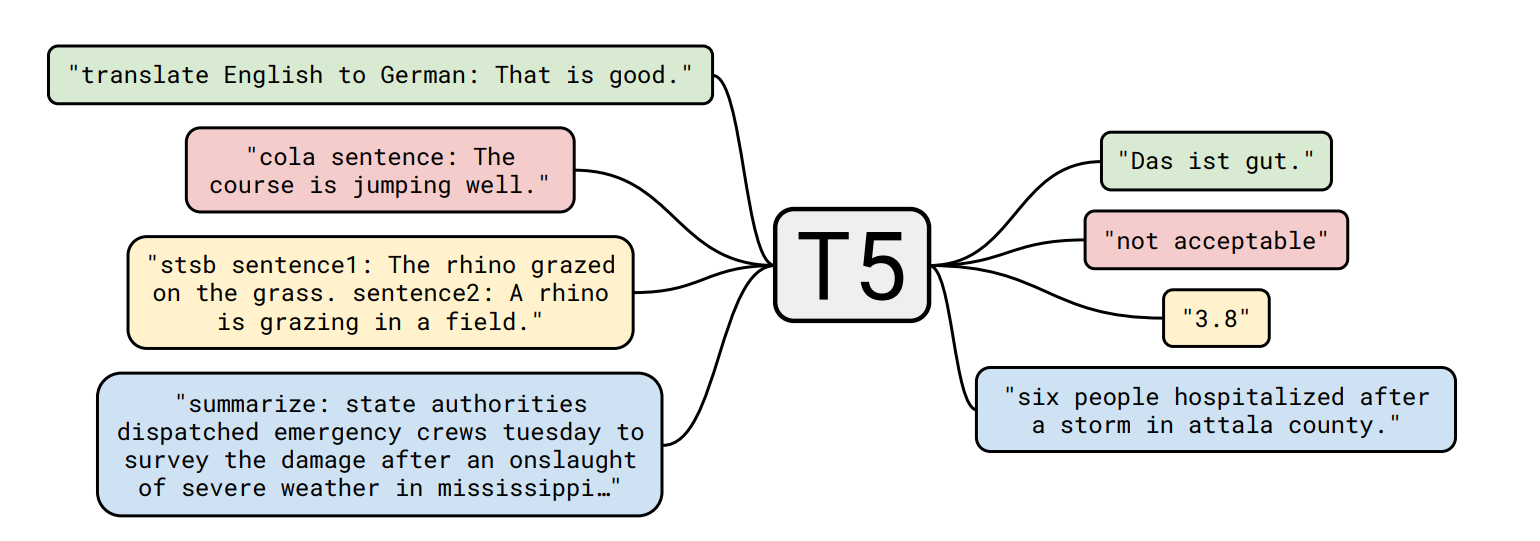

# Preprocessing
1. Prefix the input with a prompt so T5 knows this is a translation task. 

2. Tokenize the input (English) and target (French) separately.

3. Truncate sequences to be no longer than the maximum length.

In [5]:
source_lang = "en"
target_lang = "fr"
prefix = "translate English to French: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

tokenized_books = books.map(preprocess_function, batched=True)

  0%|          | 0/102 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

In [6]:
tokenized_books

DatasetDict({
    train: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 101668
    })
    test: Dataset({
        features: ['id', 'translation', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 25417
    })
})

# Evaluate
Including a metric during training is often helpful for evaluating your model’s performance. You can quickly load a evaluation method with the 🤗 Evaluate library. For this task, load the SacreBLEU metric:

In [7]:
!pip install sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 10.6 MB/s eta 0:00:00


In [8]:
import evaluate

metric = evaluate.load("sacrebleu")

For the evaluation process, we need to:
1. decode all the output ids to the words and phrases
2. remove all the leading and trailing spaces
3. calculate the bleu score

In [9]:
import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

# Train
1. Load T5 with [AutoModelForSeq2SeqLM]
2. Define a data collator
3. Define your training hyperparameters in Seq2SeqTrainingArguments. The only required parameter is output_dir which specifies where to save your model. 
4. Pass the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.
5. Call train() to finetune your model.

Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of train_dataset or eval_dataset.

To be able to build batches, data collators may apply some processing (like padding). Some of them (like DataCollatorForLanguageModeling) also apply some random data augmentation (like random masking) on the formed batch.

Here we use the `DataCollatorForSeq2Seq` that will dynamically pad the inputs received, as well as the labels.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

# Load T5 with [AutoModelForSeq2SeqLM]
model = AutoModelForSeq2SeqLM.from_pretrained("t5-small") 
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Define your training hyperparameters in Seq2SeqTrainingArguments. The only required parameter is output_dir which specifies where to save your model.
training_args = Seq2SeqTrainingArguments(
    output_dir="my_awesome_opus_books_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=2,
    predict_with_generate=True,
    fp16=False,
    push_to_hub=False,
)
# Pass the training arguments to Seq2SeqTrainer along with the model, dataset, tokenizer, data collator, and compute_metrics function.
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_books["train"],
    eval_dataset=tokenized_books["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
# Call train() to finetune your model.
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, translation. If id, translation are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 101668
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 12710
  Number of trainable parameters = 60506624
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster th

Epoch,Training Loss,Validation Loss


Saving model checkpoint to my_awesome_opus_books_model/checkpoint-500
Configuration saved in my_awesome_opus_books_model/checkpoint-500/config.json
Configuration saved in my_awesome_opus_books_model/checkpoint-500/generation_config.json
Model weights saved in my_awesome_opus_books_model/checkpoint-500/pytorch_model.bin
tokenizer config file saved in my_awesome_opus_books_model/checkpoint-500/tokenizer_config.json
Special tokens file saved in my_awesome_opus_books_model/checkpoint-500/special_tokens_map.json
Saving model checkpoint to my_awesome_opus_books_model/checkpoint-1000
Configuration saved in my_awesome_opus_books_model/checkpoint-1000/config.json
Configuration saved in my_awesome_opus_books_model/checkpoint-1000/generation_config.json
Model weights saved in my_awesome_opus_books_model/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in my_awesome_opus_books_model/checkpoint-1000/tokenizer_config.json
Special tokens file saved in my_awesome_opus_books_model/checkpoi

# Inference
now that you’ve finetuned a model, you can use it for inference.
Come up with some text you’d like to translate to another language. For T5, you need to prefix your input depending on the task you’re working on. For translation from English to French, you should prefix your input as shown below:



In [ ]:
text = "translate English to French: Welcome to the tutorial of CS6495"

There are some different text generation strategies:


* greedy decoding by calling greedy_search() if num_beams=1 and do_sample=False
* contrastive search by calling contrastive_search() if penalty_alpha>0. and top_k>1
* multinomial sampling by calling sample() if num_beams=1 and do_sample=True
* beam-search decoding by calling beam_search() if num_beams>1 and do_sample=False
* beam-search multinomial sampling by calling beam_sample() if num_beams>1 and do_sample=True
* diverse beam-search decoding by calling group_beam_search(), if num_beams>1 and num_beam_groups>1
* constrained beam-search decoding by calling constrained_beam_search(), if constraints!=None or force_words_ids!=None



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("my_awesome_opus_books_model")
inputs = tokenizer(text, return_tensors="pt").input_ids

from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("my_awesome_opus_books_model")
# top_k: The number of highest probability vocabulary tokens to keep for top-k-filtering.
# top_p:  If set to float < 1, only the smallest set of most probable tokens with probabilities that add up to top_p or higher are kept for generation.
# do_sample:  Whether or not to use sampling ; use greedy decoding otherwise.
outputs = model.generate(inputs, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)

tokenizer.decode(outputs[0], skip_special_tokens=True)

Furthur works:
1. learn more about the decoding strategies.
2. learn more about the T5 family.